# DSCI 419: Deep Learning
# Project 5
### Lauren Forti
### 04/10/2023

An RNN model is built to forecast recommendations based on review data.

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re

import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Part 1: Load the data
The data set is loaded into memory.

In [2]:
# get file path
file_path = 'C:\\Users\\laure\\Documents\\School\\DSCI 419 - Deep Learning\\Womens Clothing E-Commerce Reviews.csv'

# read in csv
reviews = pd.read_csv(file_path)

In [3]:
# look @ first few rows
reviews.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
# drop unnamed col
reviews = reviews.drop('Unnamed: 0', axis = 1)

In [5]:
# check missing values
reviews.isnull().sum(axis = 0)

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [6]:
# check datatypes
reviews.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [7]:
# list of text cols
cols = ['Title', 'Review Text', 'Division Name', 'Department Name', 'Class Name']

# replace NaNs w/ empty strings
reviews[cols] = reviews[cols].fillna('')

# convert text cols to string data type
reviews[cols] = reviews[cols].astype(str)
# check conversion
reviews.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

## Part 2: Create new feature
**Title, Review Text, Division Name, Department Name,** and **Class Name** are concatenated as a new feature, **Reviews**.

In [8]:
# make new column
reviews['Reviews'] = reviews['Title'] + ' ' + reviews['Review Text'] + ' ' + reviews['Division Name'] + ' ' + reviews['Department Name'] + ' ' + reviews['Class Name']

# check first few rows of new column
reviews['Reviews'].head()

0     Absolutely wonderful - silky and sexy and com...
1     Love this dress!  it's sooo pretty.  i happen...
2    Some major design flaws I had such high hopes ...
3    My favorite buy! I love, love, love this jumps...
4    Flattering shirt This shirt is very flattering...
Name: Reviews, dtype: object

## Part 3: Clean the new feature
The new feature, **Reviews**, is cleaned using regular expressions.

In [9]:
# remove all special characters and punctuation
reviews['Reviews'] = reviews['Reviews'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+', ' ', x))

# replace <br />
reviews['Reviews'] = reviews['Reviews'].apply(lambda x: re.sub(r'<br />', ' ', x))

# remove length <= 2
reviews['Reviews'] = reviews['Reviews'].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,2}\b', ' ', x))

# remove extra spaces
reviews['Reviews'] = reviews['Reviews'].apply(lambda x: re.sub(r'\s+', ' ', x))

# check first few output
reviews['Reviews'].head()

0     Absolutely wonderful silky and sexy and comfo...
1     Love this dress sooo pretty happened find sto...
2    Some major design flaws had such high hopes fo...
3     favorite buy love love love this jumpsuit fun...
4    Flattering shirt This shirt very flattering al...
Name: Reviews, dtype: object

## Part 4: RNN model
An RNN model is built with TensorFlow to forecast the **Recommended IND**.

In [10]:
# convert target label to numeric
le = preprocessing.LabelEncoder()
reviews['label'] = le.fit_transform(reviews['Recommended IND'])

# output count
reviews.label.value_counts()

1    19314
0     4172
Name: label, dtype: int64

In [11]:
# get features and labels
X = reviews['Reviews'].values
y = reviews['label'].values

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle = True, test_size = 0.2)

In [12]:
# specify vocab size
VOCAB_SIZE = 1000

# convert text to numeric
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = VOCAB_SIZE)

# fit state of preprocessing layer to df
encoder.adapt(X_train)

In [13]:
# build model
model = tf.keras.Sequential([
    # convert review text to indices
    encoder,
    
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 8,
        # use masking to handle variable sequence lengths
        mask_zero = True),

    # GRU layer
    tf.keras.layers.GRU(32, return_sequences = True),
    
    # LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    
    # classifier layer
    tf.keras.layers.Dense(8, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
# configure model
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(.0001),
              metrics = ['accuracy'])

In [15]:
%%time

# train model
history = model.fit(x = X_train, y = y_train, batch_size = 64, epochs = 5,
          validation_data = (X_test, y_test), verbose = 1
          )

Epoch 1/5
294/294 [==============================] - 51s 137ms/step - loss: 0.5319 - accuracy: 0.6067 - val_loss: 0.4690 - val_accuracy: 0.7876
Epoch 2/5
294/294 [==============================] - 38s 128ms/step - loss: 0.4104 - accuracy: 0.8058 - val_loss: 0.3110 - val_accuracy: 0.8495
Epoch 3/5
294/294 [==============================] - 45s 154ms/step - loss: 0.2825 - accuracy: 0.8721 - val_loss: 0.2706 - val_accuracy: 0.8812
Epoch 4/5
294/294 [==============================] - 51s 175ms/step - loss: 0.2503 - accuracy: 0.8945 - val_loss: 0.2450 - val_accuracy: 0.8904
Epoch 5/5
294/294 [==============================] - 59s 201ms/step - loss: 0.2273 - accuracy: 0.9001 - val_loss: 0.2310 - val_accuracy: 0.8940
Wall time: 4min 4s


## Part 5: Evaluate Model
The training loss versus validation loss and training accuracy versus validation accuracy are plotted. Predictions are made with the model and evaluated with a confusion matrix and a classification report. 

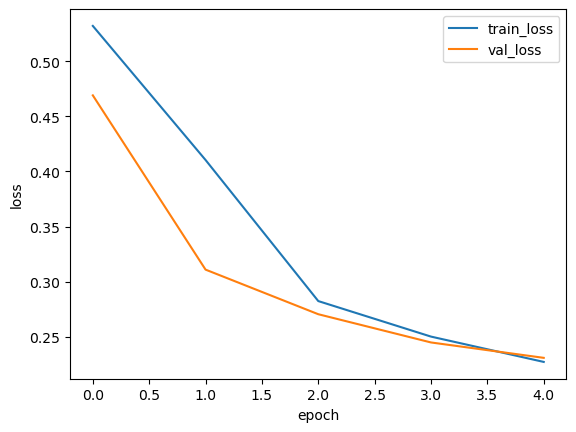

In [16]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch

# plot train + validation loss
sns.lineplot(x = 'epoch', y = 'loss', data = train_history)
sns.lineplot(x = 'epoch', y = 'val_loss', data = train_history)

# add legend
plt.legend(labels = ['train_loss', 'val_loss'])

The model is slightly overfit. 
Training loss starts around 0.55 and decreases at 2 epochs to around 0.3. It then continues decreasing with a negative slope.
Validation loss starts lower than training loss, near 0.475. It decreases with a negative slope, but crosses over training loss between 3 and 4 epochs. The decreasing training loss and higher validation loss indicates that the model is slightly overfitting.

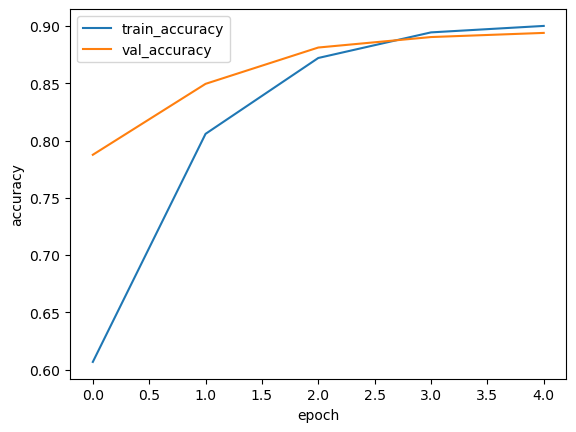

In [17]:
# plot train + validation accuracy
sns.lineplot(x = 'epoch', y = 'accuracy', data = train_history)
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = train_history)

# Add legends
plt.legend(labels = ['train_accuracy', 'val_accuracy'])

The validation accuracy and training accuracy learning curve also point to the model being slightly overfit. Validation accuracy is above training accuracy until at about 3 epochs where training becomes higher.

In [23]:
# forecast
y_pred = (model.predict(X_test) > 0.5).astype(int)

# get confusion matrix
confusion_matrix(y_test, y_pred)

147/147 [==============================] - 5s 36ms/step


array([[ 682,  153],
       [ 345, 3518]], dtype=int64)

In [24]:
# get confusion matrix labels
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(682, 153, 345, 3518)

In [25]:
# get classification report
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names = label_names))

              precision    recall  f1-score   support

    negative       0.66      0.82      0.73       835
    positive       0.96      0.91      0.93      3863

    accuracy                           0.89      4698
   macro avg       0.81      0.86      0.83      4698
weighted avg       0.91      0.89      0.90      4698



This model performs has room for improvement with how it classifies negative ("Not Recommended") reviews. The accuracy is larger than 85%, coming in at 89%. The f1-score for positive ("Recommended") reviews is 93%. This is also higher than 85% and indicates good performance. However, the f1-score for negative reviews is 73%. This is lower than 85% and can be improved.

Ultimately, the model should be refined to handle negative classification better. The current model misclassifies almost 1/4 of what are actually negative reviews as positive. 